# Examples of data analysis

This notebook shows how to analyse the sensor data example from the ABCE Open Data Project.

View the dataset here: https://figshare.com/s/68005bc2612df7f7a404

View this notebook on GitHub here: https://github.com/building-energy/ABCE_Open_Data_Project/tree/main/internal_test_datasets/sensor

## Setup

In [1]:
import requests
import json
import pandas as pd 
from matplotlib import pyplot as plt 
import io

## Get CSV file from figshare

This downloads the sensor measurement CSV file directly from the Figshare data repository.

In [2]:
csv_download_url='https://figshare.com/ndownloader/files/36203619?private_link=68005bc2612df7f7a404'
response=requests.get(csv_download_url)
csv_text=response.text
csv_text.split('\n')[:6]

['"Plot Title: 01_10_13 "\r',
 '"#","Time, GMT+01:00","Temp, °C()","RH, %()","Intensity, Lux()","Bad Battery()","Host Connected()","Stopped()","End Of File()"\r',
 '1,10/02/13 06:00:00 AM,19.865,59.728,11.8,,,,\r',
 '2,10/02/13 06:30:00 AM,19.817,59.781,11.8,,,,\r',
 '3,10/02/13 07:00:00 AM,19.793,59.747,11.8,,,,\r',
 '4,10/02/13 07:30:00 AM,19.793,60.899,11.8,,,,\r']

## Get metadata.json file from figshare

The CSV data is in CSV on the Web (CSVW) format and so there is an additional accompanying metadata file. The code below downloads this directly from the Figshare data repository.

In [3]:
metadata_json_download_url='https://figshare.com/ndownloader/files/36221052?private_link=68005bc2612df7f7a404'
response=requests.get(metadata_json_download_url)
metadata_text=response.text
metadata_dict=json.loads(metadata_text)
metadata_dict

{'@context': 'http://www.w3.org/ns/csvw',
 '@type': 'Table',
 'url': 'ABCE_atrium_U12.csv',
 'dc:title': 'Indoor conditions in the atrium of the Sir Frank Gibb building',
 'dc:description': 'Air temperature and Relative humidity data from Hobo U12 sensor placed in the atrium of the Sir Frank Gibb building',
 'dc:location': 'Atrium, Sir Frank Gibb building, Loughborough University, LE11 3TU, UK',
 'dc:creator': 'ABCE Open Research Team',
 'dialect': {'skipRows': 1},
 'tableSchema': {'@type': 'Schema',
  'columns': [{'@type': 'Column',
    'titles': '#',
    'dc:description': 'Integer count of sensor observations, starting at 1.',
    'datatype': 'integer'},
   {'@type': 'Column',
    'titles': 'Time, GMT+01:00',
    'dc:description': 'Date and time of a sensor observation, recorded at time zone Greenwich Mean Time +01:00.',
    'datatype': 'string',
    'rdfs:comment': "The 'Time, GMT+01:00' column contains values such as '10/02/13 06:00:00 AM'. This cannot be represented by the format 

## Create a parser for datetime strings in the CSV file

The 'Time, GMT+01:00' column in CSV file is a non-standard format. This functions changes the format from 'MM/dd/yy HH:mm:ss AM/PM' to 'yyyy-MM-dd HH:mm:ss'.

In [4]:
def parse_hobo_datetime_string(st):
    
    # parse initial string
    st=st.strip()
    month=int(st[0:2])
    day=int(st[3:5])
    year=int(st[6:8])
    hour=int(st[9:11])
    minute=int(st[12:14])
    second=int(st[15:17])
    AM_PM=st[18:20] 
    #print(year,month,day,hour,minute,second, AM_PM)
    
    # create 4 digit year
    year=year+2000
    
    # account for AM or PM
    if AM_PM=='PM' and not hour==12:
        hour=hour+12
    
    # create pandas Timestamp
    dt=pd.Timestamp(year,month,day,hour,minute,second)
    
    return dt

# a test of the function
parse_hobo_datetime_string('10/02/13 06:00:00 AM')

Timestamp('2013-10-02 06:00:00')

## Read data from CSV text

This reads the text from the downloaded CSV file into a Pandas DataFrame for further analysis.

In [5]:
df=pd.read_csv(io.StringIO(csv_text),
               skiprows=metadata_dict['dialect']['skipRows'],
               parse_dates=[1],
               index_col=[1],
               date_parser=parse_hobo_datetime_string  #parses the date strings using the function defined above
              )
df.columns=df.columns.str.strip()
df.head()

,#,"Temp, °C()","RH, %()","Intensity, Lux()",Bad Battery(),Host Connected(),Stopped(),End Of File()
"Time, GMT+01:00",,,,,,,,
2013-10-02 06:00:00,1,19.865,59.728,11.8,NaN,NaN,NaN,NaN
2013-10-02 06:30:00,2,19.817,59.781,11.8,NaN,NaN,NaN,NaN
2013-10-02 07:00:00,3,19.793,59.747,11.8,NaN,NaN,NaN,NaN
2013-10-02 07:30:00,4,19.793,60.899,11.8,NaN,NaN,NaN,NaN
2013-10-02 08:00:00,5,19.674,60.910,11.8,NaN,NaN,NaN,NaN


## Analysis: Plot temperature

This is an example of analysis.  

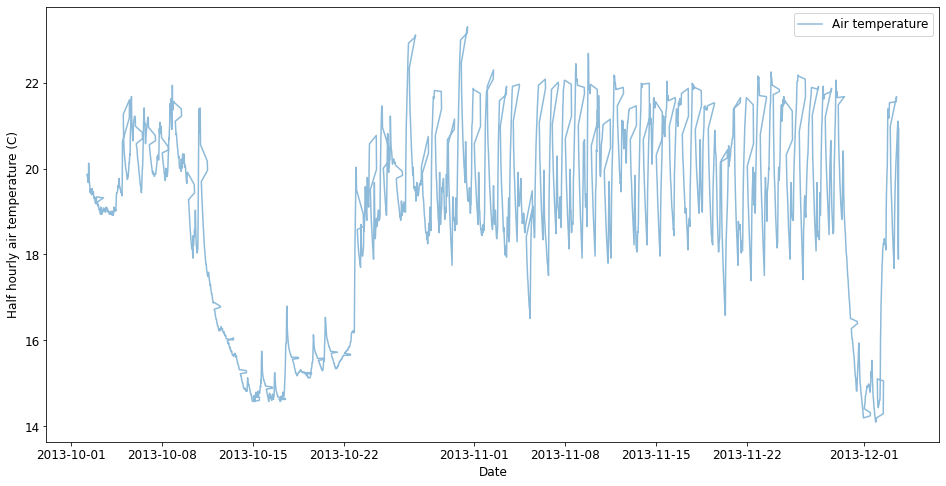

Figure X: Sensor measurements of half hourly temperatures vs. time.


In [6]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(16,8))

# finds the Column Description object in the metadata for the temperature column
for x in metadata_dict['tableSchema']['columns']:
    if x['titles']=='Temp, °C()':
        break
    
ax.plot(df[x['titles']], alpha=0.5, label=x['schema:variableMeasured'])
ax.set_xlabel('Date')
ax.set_ylabel(x['dc:description'][:-1])
ax.legend()
fig.savefig('time_series_plot.png', facecolor='white')
plt.show()
print('Figure X: Sensor measurements of half hourly temperatures vs. time.')